##### Multi Query Architecture v0

- This notebook extends the naive RAG framework to handle multiple queries simultaneously.

- This notebook involves more complex interaction with the vector storage and a parallel or multi-threaded processing approach to handle multiple data streams
- ![alt text](../sagemaker_documentation/images/MultyQuery.png)

In [1]:
# Imports:
import os
from operator import itemgetter
from dotenv import load_dotenv

from langchain.load import dumps, loads
from langchain.prompts import PromptTemplate, ChatPromptTemplate
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import UnstructuredMarkdownLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.llms import Ollama
from langchain_community.embeddings import OllamaEmbeddings

In [2]:
load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

In [3]:
DIR_PATH = "C:/Users/user/Documents/LOKA_Test/LOKA_TECNICAL_TEST_V0/sagemaker_documentation/sagemaker_documentation"
CHUNK_SIZE_SPLIT = 500
CHUNK_OVERLAP = 100
LLM_MODEL = "gpt-3.5-turbo"
# LLM_MODEL = "llama2"
TEMPERATURE = 0
SEARCH_ITEMS = 1

In [4]:
# Load documents
loader = DirectoryLoader(
    DIR_PATH, glob="*.md", loader_cls=UnstructuredMarkdownLoader
)
docs = loader.load()

In [5]:
# Split
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=CHUNK_SIZE_SPLIT, 
    chunk_overlap=CHUNK_OVERLAP
)
splits = text_splitter.split_documents(docs)

# RAGAS expects a file_name dict as key
for document in splits:
    document.metadata['file_name'] = document.metadata['source']

In [6]:
# Embed and create retriever
vectorstore = Chroma.from_documents(
    documents=splits, 
    embedding=OpenAIEmbeddings()
)

retriever = vectorstore.as_retriever(search_kwargs={"k": SEARCH_ITEMS})

In [7]:

# Multi Query: Different Perspectives
template = """You are an AI language model assistant. Your task is to generate five 
different versions of the given user question to retrieve relevant documents from a vector 
database. By generating multiple perspectives on the user question, your goal is to help
the user overcome some of the limitations of the distance-based similarity search. 
Provide these alternative questions separated by newlines. 
Original question: {question}"""

prompt_perspectives = ChatPromptTemplate.from_template(template)

generate_queries = (
    prompt_perspectives 
    | ChatOpenAI(model_name=LLM_MODEL, temperature=0) 
    | StrOutputParser() 
    | (lambda x: x.split("\n"))
)

In [8]:
generate_queries.invoke("Whe sage maker create a model what happen?")

['1. What are the outcomes when SageMaker generates a model?',
 '2. Can you explain the process and results of creating a model with SageMaker?',
 '3. What changes occur when a model is created using SageMaker?',
 "4. How does SageMaker's model creation process impact the overall system?",
 '5. What are the effects of using SageMaker to build a model?']

In [9]:
def get_unique_union(documents: list[list]):
    """ Unique union of retrieved docs """
    flattened_docs = [dumps(doc) for sublist in documents for doc in sublist]
    unique_docs = list(set(flattened_docs))

    return [loads(doc) for doc in unique_docs]

# Retrieve
question = "Whe sage maker create a model what happen?"
retrieval_chain = generate_queries | retriever.map() | get_unique_union
docs = retrieval_chain.invoke({"question":question})
len(docs)

c:\Users\user\Documents\LOKA_Test\.venv\Lib\site-packages\langchain_core\_api\beta_decorator.py:87: LangChainBetaWarning: The function `loads` is in beta. It is actively being worked on, so the API may change.
  warn_beta(


3

In [10]:
retrieval_chain.invoke({"question":question})

[Document(page_content='You create a model by running a training job in SageMaker, or by training a machine learning algorithm outside of SageMaker. If you run a training job in SageMaker, the resulting model artifacts are available in the ModelArtifacts field in the response to a call to the DescribeTrainingJob operation. For information about how to develop a SageMaker model container, see Use your own inference code. For a complete example of how to create a model container from a model trained outside of', metadata={'file_name': 'C:\\Users\\user\\Documents\\LOKA_Test\\LOKA_TECNICAL_TEST_V0\\sagemaker_documentation\\sagemaker_documentation\\sagemaker-marketplace-develop.md', 'source': 'C:\\Users\\user\\Documents\\LOKA_Test\\LOKA_TECNICAL_TEST_V0\\sagemaker_documentation\\sagemaker_documentation\\sagemaker-marketplace-develop.md'}),
 Document(page_content='Buyers use a model package to build a deployable model in SageMaker. They can use the deployable model for real-time inference by

In [11]:
# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

llm = ChatOpenAI(model_name=LLM_MODEL, temperature=0)

final_rag_chain = (
    {"context": retrieval_chain, 
     "question": itemgetter("question")} 
    | prompt
    | llm
    | StrOutputParser()
)

In [12]:
print(final_rag_chain.invoke({"question":question}))

When SageMaker creates a model, the resulting model artifacts are available in the ModelArtifacts field in the response to a call to the DescribeTrainingJob operation.


##### RAGAS TEST

In [16]:
# Ragas wants ['question', 'answer', 'contexts', 'ground_truths'] as
'''
{
    "question": [], <-- question from faq doc
    "answer": [], <-- answer from generated result
    "contexts": [], <-- context
    "ground_truths": [] <-- actual answer
}
'''

from datasets import Dataset

questions = [
    "What is SageMaker?", 
    "What are all AWS regions where SageMaker is available?",
    "How to check if an endpoint is KMS encrypted?",
    "What are SageMaker Geospatial capabilities?",
    "What is Amazon SageMaker?",
    "How does SageMaker handle model training scalability?",
    "Can SageMaker integrate with other AWS services?",
    "What are SageMaker notebooks?",
    "How does SageMaker ensure model security?",
    "What is SageMaker Autopilot?",
    "How does model monitoring work in SageMaker?",
    "What types of machine learning models can SageMaker deploy?",
    "How does SageMaker optimize model performance?",
    "Can SageMaker process real-time data for predictions?"
]

ground_truths = [
    ["SageMaker is a comprehensive AWS service that enables developers and data scientists to quickly build, train, and deploy machine learning models in the cloud."],
    ["AWS regions where SageMaker is available include North America, Europe, Asia Pacific, South America, and the Middle East."],
    ["To verify if an endpoint is encrypted with KMS, review the endpoints IAM policies and configurations in the AWS console or using the AWS CLI."],
    ["SageMakers geospatial capabilities allow you to integrate and analyze location data to improve machine learning models, applicable in areas such as logistics and environmental analysis."],
    ["Amazon SageMaker is a fully managed service that provides every developer and data scientist with the ability to build, train, and deploy machine learning models quickly."],
    ["SageMaker automatically scales the training jobs by adjusting the number of instances based on the workload, ensuring efficient use of resources."],
    ["Yes, SageMaker integrates seamlessly with AWS services like S3 for data storage, IAM for security, and Lambda for serverless computing, enhancing its capabilities."],
    ["SageMaker notebooks are Jupyter notebooks hosted on SageMaker, enabling data scientists to prepare and process data, visualize results, and experiment with models directly."],
    ["SageMaker uses AWS IAM to control access, encrypts data at rest using KMS, and data in transit using SSL to ensure secure model training and deployment."],
    ["SageMaker Autopilot is an automated machine learning (AutoML) service that automatically creates, trains, and tunes the best machine learning models based on the data provided."],
    ["SageMaker Model Monitor continuously tracks the models performance in production, detecting deviations in model quality to provide alerts and insights."],
    ["SageMaker supports all common machine learning models, including linear regression, classification, and deep learning models like CNNs and RNNs."],
    ["SageMaker optimizes models by using hyperparameter tuning to automatically find the best version of a model based on the defined criteria and metrics."],
    ["Yes, SageMaker offers real-time prediction capabilities through endpoints that are scalable and can process thousands of requests per second."]
]

answers = []
contexts = []

# Inference
for query in questions:
    answers.append(final_rag_chain.invoke({"question":query}))
    contexts.append([docs.page_content for docs in retriever.get_relevant_documents(query)])

# To dict
data = {
    "question": questions,
    "answer": answers,
    "contexts": contexts,
    "ground_truths": ground_truths
}

# Convert dict to dataset
dataset = Dataset.from_dict(data)

In [17]:
from ragas import evaluate
from ragas.metrics import (
    answer_relevancy,
    answer_similarity,
    answer_correctness,
    context_precision,
    context_recall,
    faithfulness,
    context_entity_recall
)

result = evaluate(
    dataset = dataset, 
    metrics=[
        answer_relevancy,
        answer_similarity,
        answer_correctness,
        context_precision,
        context_recall,
        faithfulness,
        context_entity_recall
    ],
)

result

passing column names as 'ground_truths' is deprecated and will be removed in the next version, please use 'ground_truth' instead. Note that `ground_truth` should be of type string and not Sequence[string] like `ground_truths`
Evaluating: 100%|██████████| 98/98 [00:48<00:00,  2.03it/s]


{'answer_relevancy': 0.8439, 'answer_similarity': 0.9293, 'answer_correctness': 0.5770, 'context_precision': 0.7143, 'context_recall': 0.8393, 'faithfulness': 0.9231, 'context_entity_recall': 0.2388}

In [18]:
import pandas as pd
pd.set_option("display.max_colwidth", None)

df = result.to_pandas()

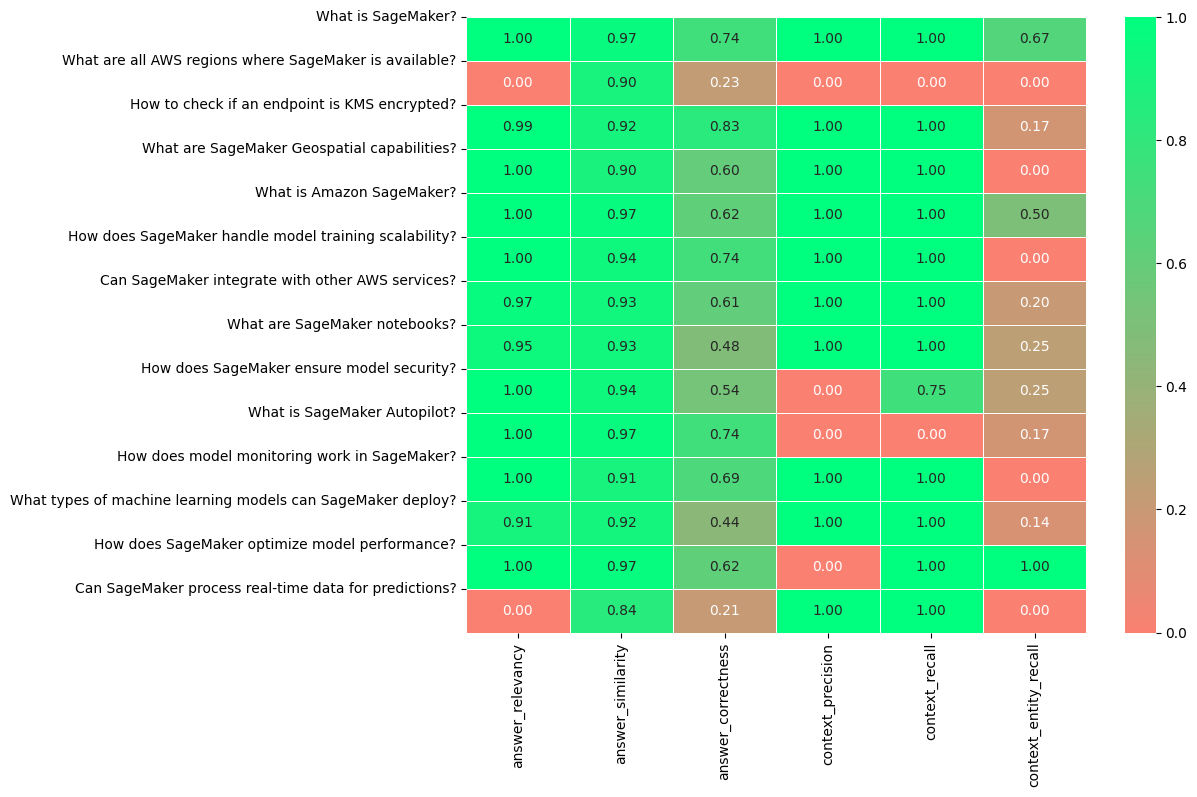

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

df = result.to_pandas()

heatmap_data = df[[
    "answer_relevancy",
    "answer_similarity",
    "answer_correctness",
    "context_precision",
    "context_recall",
    "context_entity_recall"
]]

cmap = LinearSegmentedColormap.from_list('green_red', ['salmon', 'springgreen'])

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", linewidths=.5, cmap=cmap)

plt.yticks(ticks=range(len(df['question'])), labels=df['question'], rotation=0)

plt.show()